# THE WAR AGAINST HEART ARRHYTHMIA

In [1]:
import numpy as np
import math
import pandas as pd
import scipy.signal
import matplotlib.pyplot as plt
from matplotlib.pyplot import figure
from scipy.fftpack import fft, ifft
from sklearn import preprocessing
from scipy.signal import argrelextrema
from scipy.signal import argrelmax
from numpy import where
from collections import deque
from arch.unitroot import VarianceRatio
import statsmodels.graphics.tsaplots as st
from statsmodels.tsa.stattools import acf
from scipy.signal import find_peaks
import itertools as it
from itertools import combinations
from scipy.signal import butter, filtfilt

## Preprocessing:

1. Subtract the mean from the data
2. Five order moving average filtering
3. high pass filtering with fc = 1 Hz (driftsuppression)
4. low-pass Butterworth filtering with fc = 30 Hz
5. Noise, asystole and low-quality episode segments were removed according to the corresponding annotation labels. 
6. Only the first channels of the MITDB and the VFDB have been considered to avoid dependency of samples during the learning process.

# Loading and viewing the data

In [2]:
import os
cwd = os.getcwd()
cwd

'C:\\Users\\ahmad\\Desktop\\UC3M\\Thesis\\Python_Workspace\\Code_thesis'

In [3]:
MIT_data = pd.read_csv("./Data_thesis/mitbih_database/102.csv")
MIT_data = MIT_data.iloc[:,1:3].astype("float")

In [4]:
MIT_data_col1 = MIT_data.iloc[:,0]
MIT_data_first = MIT_data_col1.astype("float")
MIT_data_first.shape

(650000,)

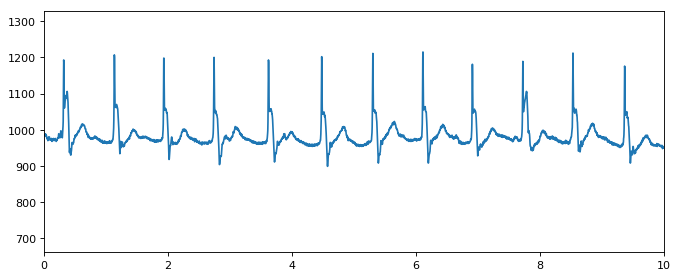

In [5]:
fs = 360
time = np.arange(MIT_data_first.size)/fs
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_data_first)

# Step 1: Subtract the mean

In [6]:
mean1 = np.mean(MIT_data.iloc[:,0])
mean2 = np.mean(MIT_data.iloc[:,1])

print(mean1)
print(mean2)

974.8292461538462
1026.5165523076923


In [7]:
MIT_data.iloc[:,0] = MIT_data.iloc[:,0] - mean1

In [8]:
MIT_data.iloc[:,1] = MIT_data.iloc[:,1] - mean2

# Step 2: Five order moving average filtering

In [9]:
def moving_average(l, N):
    sum = 0
    result = list( 0 for x in l)
 
    for i in range( 0, N ):
        sum = sum + l[i]
        result[i] = sum / (i+1)
 
    for i in range( N, len(l) ):
        sum = sum - l[i-N] + l[i]
        result[i] = sum / N
 
    return result

In [10]:
MIT_data.iloc[:,0] = moving_average(MIT_data.iloc[:,0],5)

In [11]:
MIT_data.iloc[:,1] = moving_average(MIT_data.iloc[:,1],5)

In [12]:
MIT_data = MIT_data.astype("float")

(0, 10)

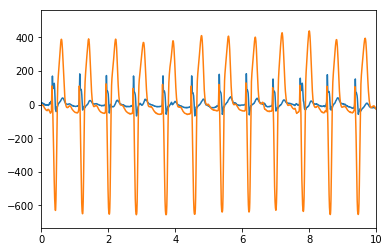

In [13]:
plt.plot(time,MIT_data)
plt.xlim(0,10)

# Step 3: High Pass Filtering with f = 1 Hz (Drift Suppression)

In [14]:
def butter_highpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='high', analog=False)
    return b, a

def butter_highpass_filter(data, cutoff, fs, order=5):
    b, a = butter_highpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [15]:
fs = 360
cutoff = 1
order = 5
MIT_conditioned_signal = butter_highpass_filter(MIT_data.iloc[:,0], cutoff, fs, order)

In [16]:
MIT_conditioned_signal

array([-4.23202213, -4.31511506, -4.39902854, ...,  3.29638229,
        1.65692434,  7.8239824 ])

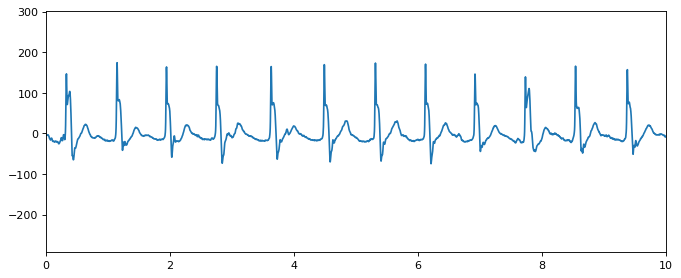

In [17]:
#time = np.arange(MIT_conditioned_signal.size)
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_conditioned_signal)

# Step 4: low-pass Butterworth filtering with fc = 30 Hz

In [18]:
def butter_lowpass(cutoff, fs, order=5):
    nyq = 0.5 * fs
    normal_cutoff = cutoff / nyq
    b, a = butter(order, normal_cutoff, btype='low', analog=False)
    return b, a

def butter_lowpass_filter(data, cutoff, fs, order=5):
    b, a = butter_lowpass(cutoff, fs, order=order)
    y = filtfilt(b, a, data)
    return y

In [19]:
order = 5
fs = 30
cutoff = 1

MIT_signal = butter_lowpass_filter(MIT_conditioned_signal, cutoff, fs, order)

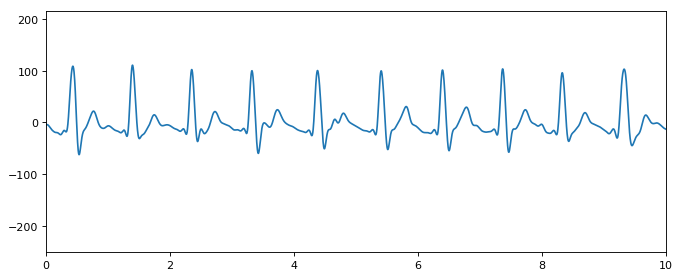

In [20]:
fs=30
time = np.arange(MIT_signal.size)/fs
time = time/10
figure(num=None, figsize=(10, 4), dpi=80, facecolor='w', edgecolor='k')
plt.xlim((0, 10))
#plt.ylim((930,1050))
plt.plot(time,MIT_signal)

# Time parameter

In [21]:
t_cst = len(MIT_signal)/time[-1]
t_cst  ##number of signal points in 1 second

300.00046153917157

## Parameter 1: TCI

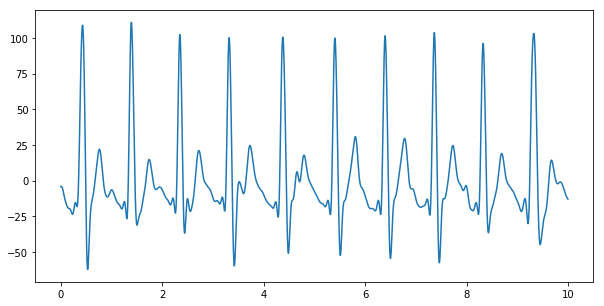

In [24]:
MIT_signal.size
time.size
time[300]
time[600]
plt.figure(figsize=(10,5))
plt.plot(time[0:3000],MIT_signal[0:3000])

In [25]:
def binary_td(signal,m,n):
    threshold = np.arange(n-m).astype("float")
    k = m
    s = m
    z = 0
    binary_list = []
    i=0
    while(i < threshold.size):
        threshold[i]=0.2*np.amax(MIT_signal[int(np.ceil(m*300)):int(np.ceil((m+1)*300))])
        i+=1
        m+=1
    for l in threshold:
        p = 0
        for j in signal[int(np.ceil(k*300)):int(np.ceil((k+1)*300))]:
            if j < l :
                binary_list.append(0)
            else: 
                binary_list.append(1)
        k+=1
    plt.figure(figsize=(10,5))
    plt.plot(time[s*300:n*300],binary_list)
    return np.array(binary_list),threshold

array([0, 0, 0, ..., 0, 0, 0])

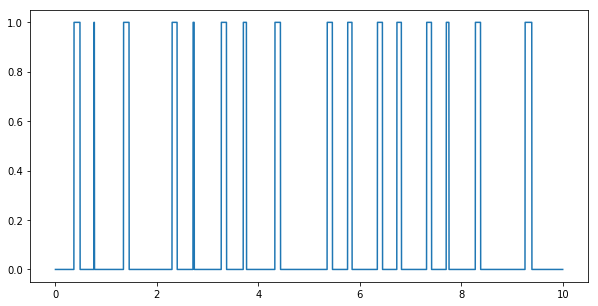

In [26]:
binlist,thd = binary_td(MIT_signal,0,10)
binlist[300:2700]

In [27]:
def TCI(binlist,thd,m,n):
    pulses = [0]*(n-m+2)
    q = 0
    p = 300
    ## pulse calculation:
    k=0
    for i in range(len(thd)):
        bin2 = binlist[q:p]
        for i in range(len(bin2)-1):
            if bin2[i]!=bin2[i+1]:
                pulses[k]+=1
        pulses[k] = pulses[k]/2
        k+=1
        q+=300
        p+=300
    q = 0
    p=900
    k=0
    t1_idx = 0
    t2_idx = 0
    t3_idx = 0
    t4_idx = 0
    TCI=[]
    for l in range(len(thd)-2):
        countidx1 = 0
        countidx2 = 0
        countidx3 = 0
        countidx4 = 0
        bin2 = binlist[q:p]
        
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx1+=1
                if countidx1/2 == pulses[k]:
                    t1_idx = f+q
                    break
        h1 = q+300
        bin2=binlist[h1:p]
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t2_idx = h1+f+1
                break
                    
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                countidx3 +=1
                if countidx3/2 == pulses[k+1]:
                    t3_idx = f+h1
                    break
        h2 = q+600            
        bin2 =binlist[h2:p]             
        for f in range(len(bin2)-1):
            if bin2[f]!=bin2[f+1]:
                t4_idx = f+1+h2
                break
        t1 = (h1-t1_idx)/300
        t2 = (t2_idx-h1)/300
        t3 = (h2 - t3_idx)/300
        t4 = (t4_idx-h2)/300
        
        form1 = (pulses[k+1]-1)+(t2/(t1+t2))+(t3/(t3+t4))
        form2=1000/form1
        TCI.append(form2)
        q+=300
        p+=300
        k+=1
    return np.array(TCI)

array([804.87137384, 540.58858384, 519.96025149, 837.8015606 ,
       589.08778502, 486.52131887, 475.13366287, 808.4102124 ])

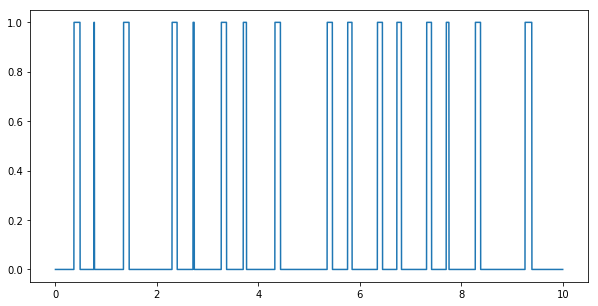

In [28]:
binlist,thd = binary_td(MIT_signal,0,10)
TCI(binlist,thd,1,9)

## Parameter 2: ACF

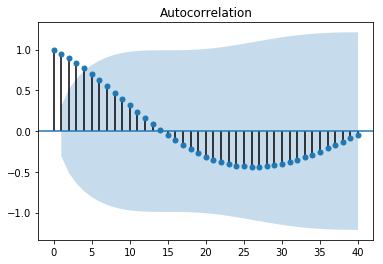

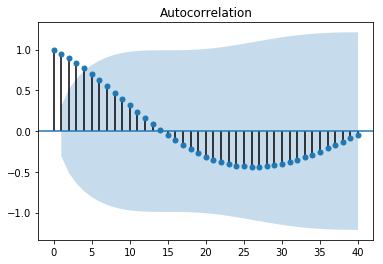

In [118]:
ser = acf(MIT_signal[0:2000],6)
st.plot_acf(ser)

In [119]:
ser

array([ 1.        ,  0.99710861,  0.98748333,  0.97124027,  0.94857714,
        0.91976956,  0.8851659 ,  0.8451808 ,  0.80028763,  0.75100996,
        0.69791242,  0.64159094,  0.58266286,  0.52175699,  0.4595038 ,
        0.39652607,  0.33343009,  0.27079754,  0.20917825,  0.14908384,
        0.09098241,  0.0352942 , -0.01761171, -0.06741968, -0.11386882,
       -0.15675337, -0.19592223, -0.23127774, -0.2627737 , -0.29041281,
       -0.3142436 , -0.33435682, -0.35088158, -0.36398106, -0.37384811,
       -0.38070063, -0.38477683, -0.38633056, -0.38562657, -0.38293591,
       -0.37853146])

In [120]:
vr = VarianceRatio(ser,6)
vr.overlap=False
print(vr)

     Variance-Ratio Test Results     
Test Statistic                  8.227
P-value                         0.000
Lags                                6
-------------------------------------

Computed with non-overlapping blocks


## Parameter 3: VF Filter

In [121]:
def get_points(signal,m):
    i=1
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i])
        y = y + np.absolute(signal[i]-signal[i-1])
        i+=1
    N = np.floor(np.pi*(x/y)+0.5)
    return N

def leakage(signal,N,n,m):
    i=n
    x=0
    y=0
    while i <= m:
        x = x + np.absolute(signal[i]+signal[i-N])
        y = y + (np.absolute(signal[i])+np.absolute(signal[i-N]))
        i+=1
    l = x/y
    return l
    

In [122]:
get_points(MIT_signal,300)

49.0

In [123]:
leakage(MIT_signal,int(get_points(MIT_signal,300)),200,500)

0.6344872215219527

## Parameter 4: Spectral Algorithm

In [124]:
Ham = MIT_signal[0:2400]*np.hamming(2400)

(-120, 120)

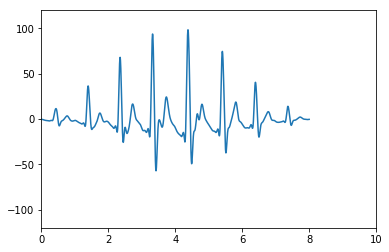

In [125]:
plt.plot(time[0:2400],Ham)
plt.xlim(0,10)
plt.ylim(-120,120)

In [107]:
fourier = scipy.fft(Ham)

In [108]:
fourier

array([-5.50897688+0.j        , -5.68080042+0.04209101j,
       -6.30559754+0.23384608j, ..., -9.66289421-3.78073608j,
       -6.30559754-0.23384608j, -5.68080042-0.04209101j])

(0, 10)

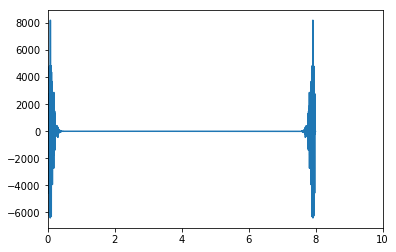

In [110]:
plt.plot(time[0:2400],fourier)
plt.xlim(0,10)

In [111]:
def fourier_abs(fourier):
    j=0
    for i in fourier:
        fourier[j] = np.absolute(i.real)+np.absolute(i.imag)
        j+=1
    return fourier

In [112]:
fourier_2 = fourier_abs(fourier)

In [113]:
fourier_2

array([ 5.50897688+0.j,  5.72289144+0.j,  6.53944362+0.j, ...,
       13.44363029+0.j,  6.53944362+0.j,  5.72289144+0.j])

(0, 10)

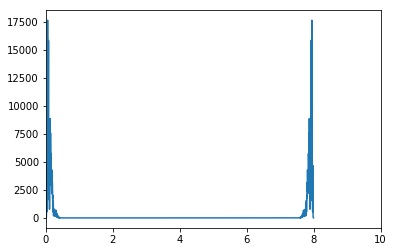

In [116]:
plt.plot(time[0:2400],fourier_2)
plt.xlim(0,10)

In [117]:
freq_1 = 0.5
freq_2 = 9

time_1 = 1/9
time_2 = 1/0.5

range1 = int(np.ceil(time_1*300))
range2 = int(np.floor(time_2*300))

fourier_3 = fourier_2[range1:range2]

In [55]:
m = np.amax(fourier_3)
f = fourier_3.tolist()
print(f.index(m))
print(m)

534
(39.202156761856905+0j)


In [56]:
time_max_amp = f.index(m)/300 ## in seconds
God_of_War = 1/time_max_amp
God_of_War

0.5617977528089888

In [57]:
def amp_maxsetter(fourier,m):
    j = 0
    for i in fourier:
        if i < 0.05*m:
            fourier[j]=0
        j+=1
    return fourier

In [58]:
fourier_final = amp_maxsetter(fourier_2,m)
fourier_final

array([30.31516534+0.j, 30.3288039 +0.j, 30.34666215+0.j, ...,
       30.36250248+0.j, 30.34666215+0.j, 30.3288039 +0.j])

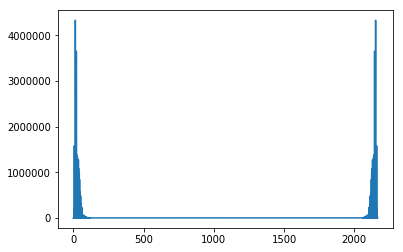

In [59]:
plt.plot(time,fourier_final)

In [60]:
def moment_calc(fourier,omega,jmax):
    j=0
    s=0
    fft = fourier[0:int(np.amin([20*omega,100]))]
    while j <= jmax:
        freq = 300/j   ##fix time
        m = 1/omega
        s = s + (m*freq)
        j+=1

In [61]:
# moment_calc(fourier_final,God_of_War,f.index(m))

## Parameter 5: Complexity Measure Algorithm

In [38]:
nurgle = MIT_signal[0:2400]
meanbean = np.mean(nurgle)
nurgle = nurgle - meanbean
Vp = np.amax(nurgle)
Vn = np.amin(nurgle)

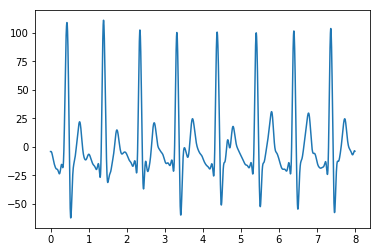

In [39]:
plt.plot(time[0:2400],nurgle)

In [40]:
def Td(Vp,Vn,nurgle):
    pc = 0
    nc = 0
    for i in nurgle:
        if i>0 and i<0.1*Vp:
            pc+=1
        elif i<0 and i>0.1*Vn:
            nc+=1
    if pc+nc < 0.4*len(nurgle):
        T = 0
    elif pc<nc:
        T = 0.2*Vp
    elif pc>nc:
        T = 0.2*Vn
    return T

In [41]:
Threshold = Td(Vp,Vn,nurgle)
Threshold

0

In [42]:
def binary_comp(Threshold,nurgle):
    s = []
    for i in nurgle:
        if i<Threshold:
            s.append(0)
        else:
            s.append(1)
    return np.array(s)

In [43]:
binary = binary_comp(Threshold,nurgle)
binary

array([0, 0, 0, ..., 0, 0, 0])

In [44]:
def substrings(string):
    length = len(string)
    alist = []
    for i in range(length):
        for j in range(i,length):
            alist.append(string[i:j + 1]) 
    return alist

def complexity(binary):
    cn = 1
    S = [binary[0]]
    Q = [binary[1]]
    m = 0
    while 2 < 3:
        con = S+Q
        con = con[:-1]
        C=substrings(con)
        if Q not in C:
            m = 0
            S = S+Q
            if len(S) == len(binary)-1:
                cn+=1
                break
            Q = [binary[len(S)]]
            cn+=1
        elif Q in C:
            k = len(S)+m
            if k < len(binary):
                Q = Q+[binary[len(S)+m]]
                m+=1
            else:
                break
    return cn

In [45]:
cn=complexity(binary[0:200])
cn

3

In [71]:
#cn = complexity(binary[0:200])
#cn
S= ['A','B','C','D','E']
Q= ['F']

sq = S+Q
combi = combinations(sq,5)
list(combi)

[('A', 'B', 'C', 'D', 'E'),
 ('A', 'B', 'C', 'D', 'F'),
 ('A', 'B', 'C', 'E', 'F'),
 ('A', 'B', 'D', 'E', 'F'),
 ('A', 'C', 'D', 'E', 'F'),
 ('B', 'C', 'D', 'E', 'F')]

In [119]:
bn = len(binary)/(math.log2(len(binary)))

In [120]:
complexity_measure = cn/bn
complexity_measure

0.014036023363119852

## Parameter 6: Standard Exponential Algorithm

In [126]:
def exp_algthm(t,signal,Tau):
    M = np.amax(signal)
    tm = (np.where(MIT_signal==M))[0]/300
    exp_part = np.exp((-1*np.absolute(t-tm))/Tau)
    curve = M*exp_part
    
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,curve)
    idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
    plt.plot(t[idx],signal[idx],'ro')
    
    Time_length = len(signal)/300
    int_num = len(idx)
    N = (int_num/Time_length)*60
    return N

142.5

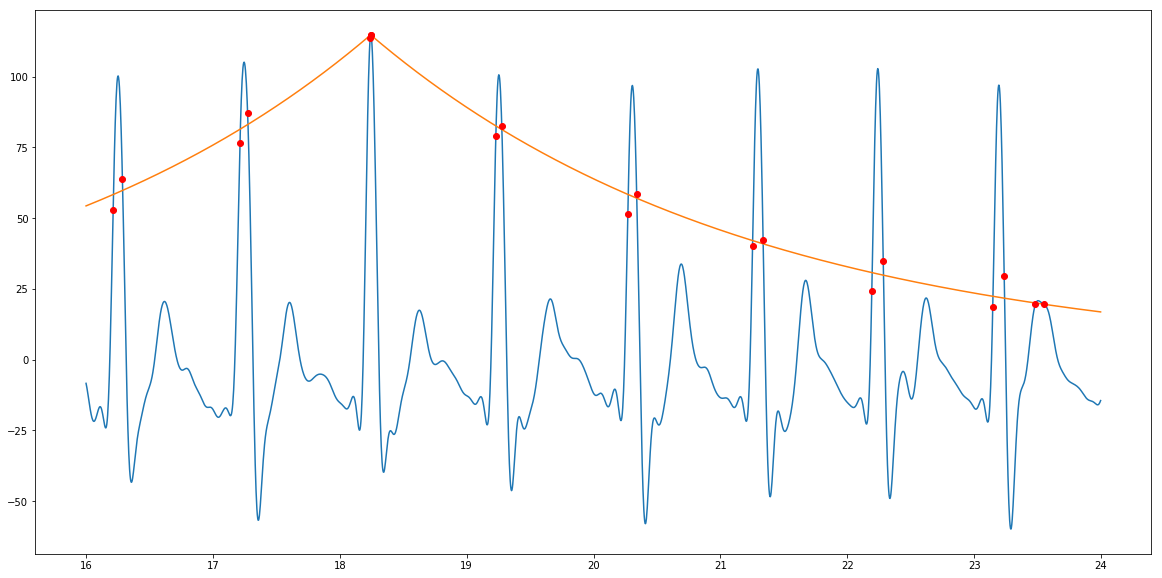

In [127]:
exp_algthm(time[4800:7200],MIT_signal[4800:7200],3)

## Parameter 7: Modified Exponential Algorithm

In [34]:
def MEA(t,signal,Tau):
    index_M = argrelextrema(signal,np.greater)
    index_realM = []
    for j in index_M[0]: 
        if signal[j] > 0.5*np.amax(signal):
            index_realM.append(j)
    tm = np.array(index_realM)/300
    real_curve = [1.0]*len(t)
    k = 0
    for j in index_realM:
        Mj = MIT_signal[j]
        tmj = tm[k]
        if k <= len(tm)-2:
            tmj1 =tm[k+1]
        else: 
            tmj1 = 2200
        exp_part = np.exp((-1*(t-tmj))/Tau)
        curve = Mj*exp_part
        idx = np.argwhere(np.diff(np.sign(signal-curve))).flatten()
        l = 0
        for i in t: 
            tc = np.array(idx)/300
            tcj = tc[-2]
            if tmj <= i and i <=tcj:
                real_curve[l]=(curve[np.where(t == i)].item())
            elif tcj<= i and i <= tmj1:
                real_curve[l]=(signal[np.where(t == i)].item())
            l+=1
        k+=1
    idx = np.argwhere(np.diff(np.sign(signal-real_curve))).flatten()
    plt.figure(figsize=(20,10))
    plt.plot(t,signal)
    plt.plot(t,real_curve)
    plt.plot(t[idx],signal[idx],'ro')
    
    numberofint = len(idx)
    Time_length = len(signal)/300
    N = numberofint/Time_length
    return N*60
#####DRAW THE WHOLE FUNCTION FIRST THEN TRY TO REPLACE

292.5

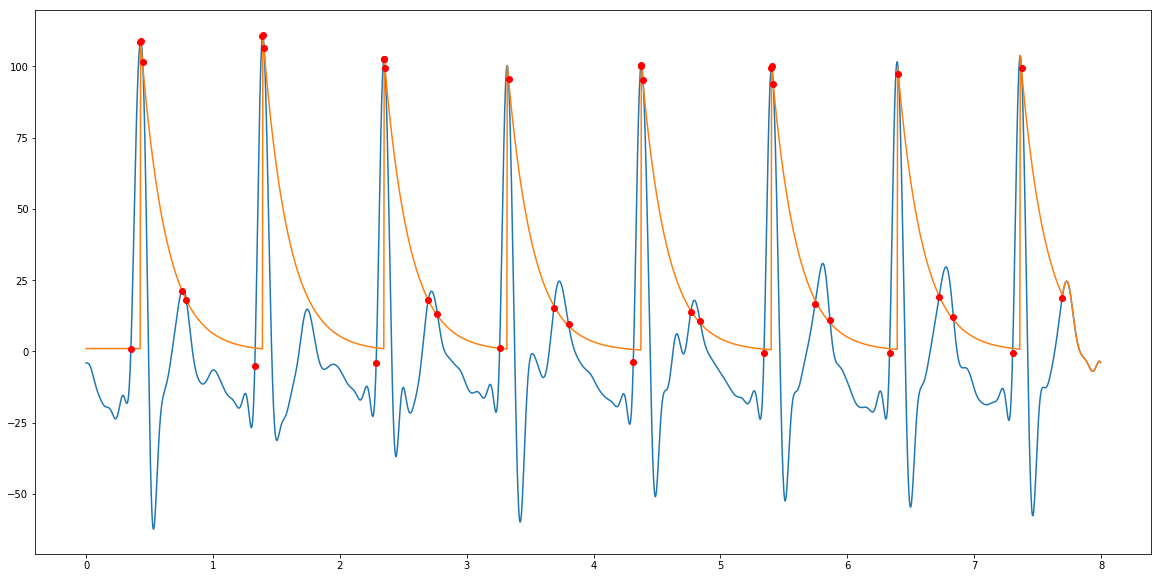

In [35]:
MEA(time[0:2400],MIT_signal[0:2400],0.2)

In [48]:
index_M = argrelextrema(signal, np.greater)

tm = np.array(index_M[0])/300
tm

NameError: name 'signal' is not defined

In [ ]:
np.amax(time)

In [ ]:
i_m = argrelextrema(signal,np.greater)


In [128]:
(15/8)*60

112.5

## Parameter 8: Signal Comparison

In [100]:
def M0_creator(signal,time):
    M = argrelextrema(signal,np.greater)
    M0=np.zeros((len(M[0]),2))
    k=0
    for i in M[0]:
        M0[k,0] = time[i]
        M0[k,1] = signal[i]
        k+=1
    return M0

(-50, 200)

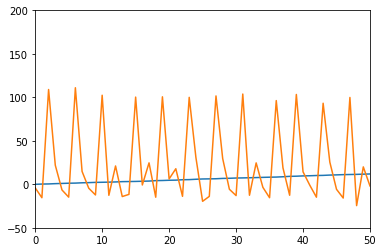

In [113]:
M0 = M0_creator(MIT_signal,time)
plt.plot(M0)
plt.xlim(0,50)
plt.ylim(-50,200)

In [2]:
M = argrelextrema(MIT_signal[0:2400],np.greater)
M

NameError: name 'argrelextrema' is not defined

In [1]:
M0=np.zeros((10,2))
M0

M0[1,0] = time[1]
M0

NameError: name 'np' is not defined